In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
from model.vae import aligned_vae, vae
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import diffusion_dist as diff
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from dataset import *
import scipy

In [2]:
pd_atac = pd.read_csv('./data/expr_atac_processed.csv', index_col=0)
pd_rna = pd.read_csv('./data/expr_rna_processed.csv', index_col=0)
atac = pd_atac.to_numpy()
rna = pd_rna.to_numpy()

In [3]:
def pairwise_distance(x):
    x_norm = (x**2).sum(1).view(-1, 1)
    y_norm = x_norm.view(1, -1)
    dist = x_norm + y_norm - 2.0 * torch.mm(x, torch.transpose(x, 0, 1))
    return dist 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = scDataset(dim_reduction=False)
testset = testDataset()

In [5]:
pca = PCA(n_components=30)

# atac_lsi = latent_semantic_indexing(atac, k = 30)
atac_pca = pca.fit_transform(atac)

rna_pca = pca.fit_transform(np.log1p(rna))

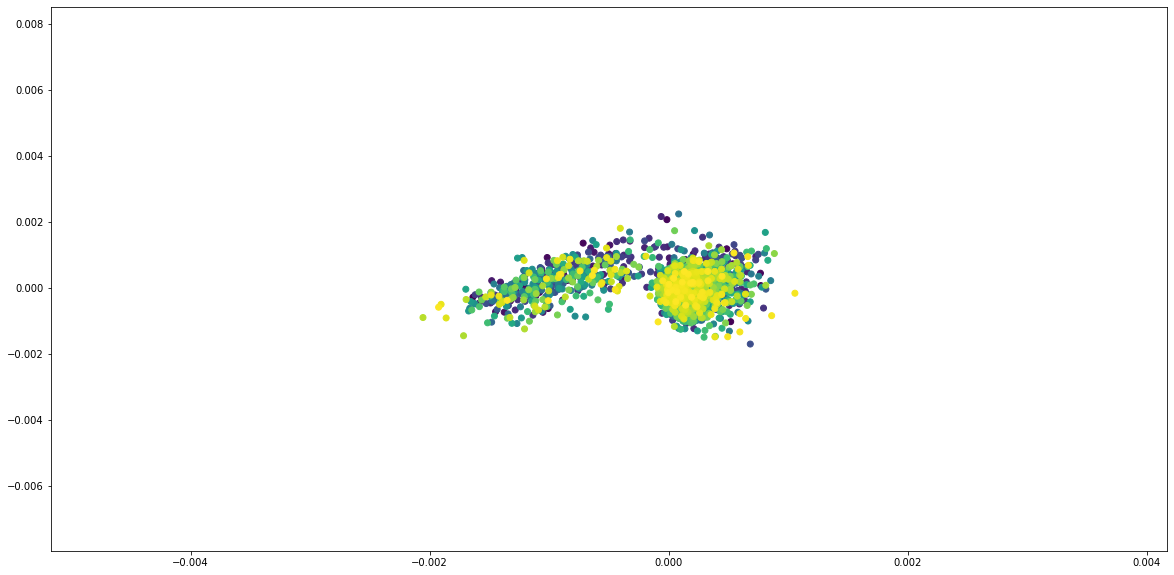

In [6]:
diffu_atac = diff.diffusion_map(atac_pca, n_eign = 10, alpha = 100, diffusion_time = 5)
diff_sim_atac = diff.diffusion_similarity(diffu_atac)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu_atac[:,2], diffu_atac[:,1], c=np.arange(atac.shape[0]))

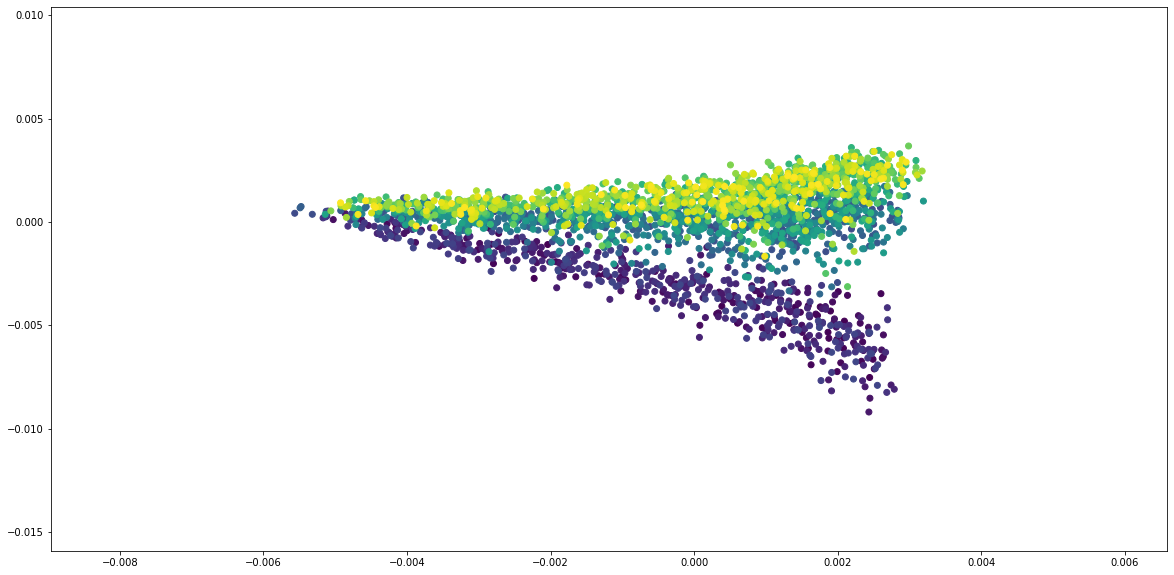

In [7]:
diffu = diff.diffusion_map(rna_pca, n_eign = 10, alpha = 15, diffusion_time = 5)
diff_sim_rna = diff.diffusion_similarity(diffu)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(diffu[:,1], diffu[:,2], c=np.arange(rna.shape[0]))


In [8]:
# normalize both matrices for inner product loss
diff_sim_atac = torch.FloatTensor(diff_sim_atac).to(device)
diff_sim_rna = torch.FloatTensor(diff_sim_rna).to(device)
diff_sim_atac = diff_sim_atac / torch.norm(diff_sim_atac, p = 'fro')
diff_sim_rna = diff_sim_rna / torch.norm(diff_sim_rna, p = 'fro')

In [9]:
# pca calculated internally, no need to do pca before
DPT_atac = diff.DPT_similarity(atac)
DPT_rna = diff.DPT_similarity(rna)

# normalize both matrices for inner product loss
DPT_atac = torch.FloatTensor(DPT_atac).to(device)
DPT_rna = torch.FloatTensor(DPT_rna).to(device)
DPT_atac = DPT_atac / torch.norm(DPT_atac, p = 'fro')
DPT_rna = DPT_rna / torch.norm(DPT_rna, p = 'fro')

In [10]:
def dist_loss_kl(recon_atac, recon_rna, atac, rna, z, diff_atac, diff_rna, logvarz, muz, lamb, lamb_atac, dist_loss_type = "cosine", beta=0.01):
    loss_recon_rna = F.mse_loss(rna, recon_rna)
    loss_recon_atac = lamb_atac * F.mse_loss(atac, recon_atac)

    # cosine similarity loss, don't forget to normalize the matrix before calculate inner product
    if dist_loss_type == "cosine":
        # diff_atac and diff_rna are only constant, but better to be normalized
        Sim = pairwise_distance(z)
        # normalize latent similarity matrix
        Sim = Sim / torch.norm(Sim, p='fro')

        # inner product loss, maximize, so add negative before, in addition, make sure those two values are normalized, with norm 1
        loss_dist_atac = - lamb * torch.sum(diff_atac * Sim)
        loss_dist_rna = - lamb * torch.sum(diff_rna * Sim)

    # pearson correlationship
    elif dist_loss_type == "pearson":
        Sim = pairwise_distance(z)
        Vs = Sim - torch.mean(Sim)

        Vd_atac = diff_atac - torch.mean(diff_atac)
        Vd_rna = diff_rna - torch.mean(diff_rna)

        # maximize correlationship
        loss_dist_atac = - lamb * torch.sum(Vs * Vd_atac) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_atac ** 2)))
        loss_dist_rna = - lamb * torch.sum(Vs * Vd_rna) / (torch.sqrt(torch.sum(Vs ** 2)) * torch.sqrt(torch.sum(Vd_rna ** 2)))
    
    # mse loss
    elif dist_loss_type == "mse":
        loss_dist_atac = lamb * F.mse_loss(diff_atac.reshape(-1), pairwise_distance(z).reshape(-1))
        loss_dist_rna = lamb * F.mse_loss(diff_rna.reshape(-1), pairwise_distance(z).reshape(-1))

    loss_kl = beta * 0.5 * torch.sum(- logvarz + torch.exp(logvarz) + muz * muz - 1)

    loss = loss_recon_rna + loss_recon_atac + loss_dist_atac + loss_dist_rna + loss_kl
    return loss, loss_recon_rna, loss_recon_atac,  loss_dist_atac,  loss_dist_rna, loss_kl

In [11]:
def train_vae(model, data_loader, lamb = 10, lamb_var = 0.1, lamb_atac = 50, beta = 0.01, similarity = "DPT"):
    model.train()

    total_loss = 0
    total_loss_recon_rna = total_loss_recon_atac = 0
    total_loss_dist_atac = total_loss_dist_rna = 0
    total_loss_var = 0
    total_loss_kl = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_atac, recon_rna, z, logvarz, muz = model(batch_atac, batch_rna)

        if similarity == "DPT":
            batch_diff_atac = DPT_atac[data['index'], :][:, data['index']]
            batch_diff_rna = DPT_rna[data['index'], :][:, data['index']]           
        elif similarity == "diffusion map":
            batch_diff_atac = diff_sim_atac[data['index'], :][:, data['index']]
            batch_diff_rna = diff_sim_rna[data['index'], :][:, data['index']]

        loss = dist_loss_kl(recon_atac, recon_rna, batch_atac, batch_rna, z, batch_diff_atac, batch_diff_rna, logvarz, muz, lamb = lamb, lamb_atac = lamb_atac, dist_loss_type= 'cosine', beta=beta)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_recon_atac += loss[2]
        total_loss_dist_rna += loss[3]
        total_loss_dist_atac += loss[4]
        total_loss_kl += loss[5]

        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()

    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_recon_atac.item() / len(data_loader), \
 total_loss_dist_rna.item() / len(data_loader), total_loss_dist_atac.item() / len(data_loader), total_loss_kl / len(data_loader)

In [12]:
def test_vae(model, data_loader):
    model.eval()
    
    for data in data_loader:
        # print("test ", count)
        recon_atac, recon_rna, z, logvarz, muz = model(torch.FloatTensor(data['ATAC']).to(device), data['RNA'].to(device))
        z = z.detach().cpu().numpy()

        print("ATAC reconstruction loss", F.mse_loss(data['ATAC'].to(device), recon_atac).item())
        print("RNA reconstruction loss", F.mse_loss(data['RNA'].to(device), recon_rna).item())

    return recon_atac, recon_rna, z, logvarz, muz

In [14]:
rna.shape

(2641, 1185)

In [16]:
atac.shape

(2641, 9467)

## Variational Autoencoder

In [17]:
train_loader = DataLoader(dataset, shuffle=True, batch_size=32)
test_loader = DataLoader(dataset, shuffle=True, batch_size=len(dataset))

model_vae = aligned_vae(in_channels_atac=atac.shape[1], in_channels_rna=rna.shape[1], latent_channels_atac=1024, latent_channels_rna=128, latent_channels_z=32, layer1_channels= 1024, layer2_channels=512).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=5e-4, weight_decay=0.01)

for epoch in range(0, 801):

    loss, l1, l2, l3, l4, l5 = train_vae(model_vae, data_loader = train_loader, lamb = 0, lamb_atac = 0,  beta=1, similarity = "DPT")
    if epoch % 10 == 0:
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, Recon ATAC loss {:.5f}, Dist RNA loss {:.5f}, Dist ATAC loss {:.5f}, KL loss: {:.5f}"
        print(log.format(epoch, loss, l1, l2, l3, l4, l5))

Epoch: 000, Total loss: 0.98927, Recon RNA loss: 0.67231, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.31696
Epoch: 010, Total loss: 0.61055, Recon RNA loss: 0.61055, Recon ATAC loss 0.00000, Dist RNA loss 0.00000, Dist ATAC loss 0.00000, KL loss: 0.00000


KeyboardInterrupt: 

ATAC reconstruction loss67.44660186767578
RNA reconstruction loss122.526611328125


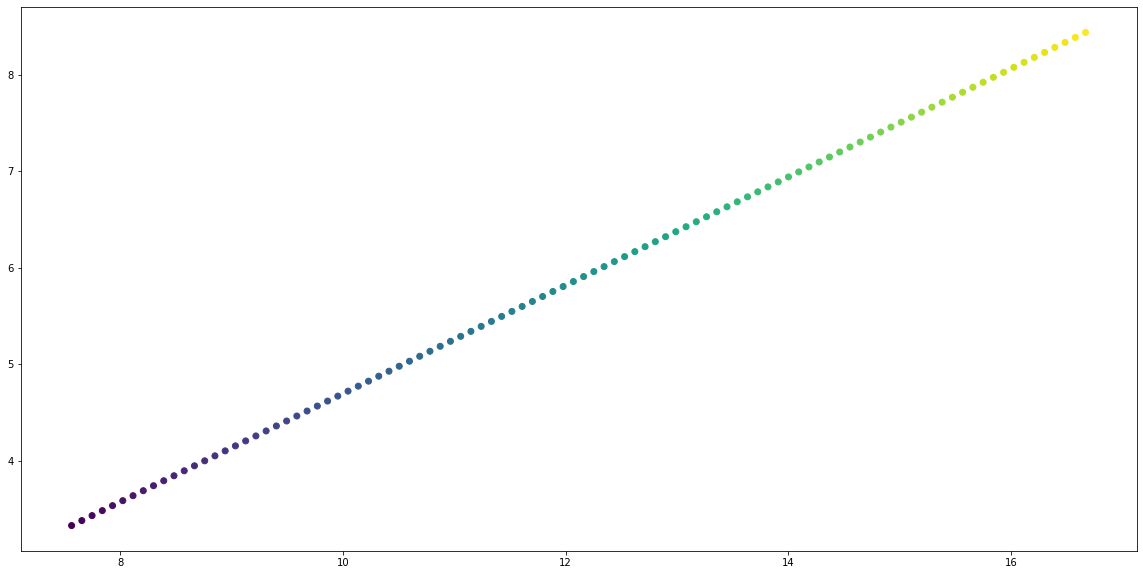

In [62]:
recon_atac, recon_rna, z, logvarz, muz = test_vae(model_vae, test_loader)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,0], z[:,1], c=np.arange(rna.shape[0]))

In [63]:
recon_atac

tensor([[ 32.2891,  32.6164,  33.1628,  ...,  79.8152,  80.4322,  80.8695],
        [ 32.8097,  33.1468,  33.6997,  ...,  81.0479,  81.6702,  82.1156],
        [ 33.3302,  33.6772,  34.2367,  ...,  82.2806,  82.9083,  83.3617],
        ...,
        [ 82.8006,  84.0799,  85.2627,  ..., 199.4229, 200.5587, 201.7802],
        [ 83.3214,  84.6105,  85.7999,  ..., 200.6562, 201.7973, 203.0269],
        [ 83.8423,  85.1412,  86.3371,  ..., 201.8895, 203.0360, 204.2736]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [14]:
def simple_loss_kl(recon_rna, rna, z, logvarz, muz, beta=0.01):
    loss_recon_rna = F.mse_loss(rna, recon_rna)

    loss_kl = beta * 0.5 * torch.sum(- logvarz + torch.exp(logvarz) + muz * muz - 1)
    loss = loss_recon_rna + loss_kl
    return loss, loss_recon_rna, loss_kl

In [15]:
def simple_train_vae(model, data_loader, beta = 0.01, similarity = "DPT"):
    model.train()
    total_loss = 0
    total_loss_recon_rna = 0
    total_loss_kl = 0
    for data in data_loader:
        optimizer.zero_grad()
        batch_atac = data['ATAC'].to(device)
        batch_rna = data['RNA'].to(device)
        recon_rna, z, logvarz, muz = model(batch_rna)

        loss = simple_loss_kl(recon_rna, batch_rna, z, logvarz, muz, beta=beta)
        total_loss += loss[0]
        total_loss_recon_rna += loss[1]
        total_loss_kl += loss[2]

        current_loss = loss[0]
        current_loss.backward()
        optimizer.step()

    return total_loss.item() / len(data_loader), total_loss_recon_rna.item() / len(data_loader), total_loss_kl / len(data_loader)

In [32]:
train_loader = DataLoader(dataset, shuffle=False, batch_size=32)
test_loader = DataLoader(dataset, shuffle=False, batch_size=len(dataset))

model_vae = vae(in_channels=rna.shape[1], latent_channels=16, layer1_channels=128, layer2_channels=64).to(device)
optimizer = torch.optim.Adam(model_vae.parameters(), lr=1e-5, weight_decay=0.005)

for epoch in range(0, 101):

    loss, l1, l2= simple_train_vae(model_vae, data_loader = train_loader, beta=0.1, similarity = "DPT")
    if epoch % 10 == 0:                
        log = "Epoch: {:03d}, Total loss: {:.5f}, Recon RNA loss: {:.5f}, KL loss: {:.5f}"
        print(log.format(epoch, loss, l1, l2))

Epoch: 000, Total loss: 1.23720, Recon RNA loss: 1.03758, KL loss: 0.19962
Epoch: 010, Total loss: 1.00646, Recon RNA loss: 0.99653, KL loss: 0.00992
Epoch: 020, Total loss: 0.82241, Recon RNA loss: 0.81737, KL loss: 0.00504
Epoch: 030, Total loss: 0.64378, Recon RNA loss: 0.64060, KL loss: 0.00318
Epoch: 040, Total loss: 0.62068, Recon RNA loss: 0.61865, KL loss: 0.00203
Epoch: 050, Total loss: 0.61597, Recon RNA loss: 0.61455, KL loss: 0.00142
Epoch: 060, Total loss: 0.61456, Recon RNA loss: 0.61351, KL loss: 0.00104
Epoch: 070, Total loss: 0.61424, Recon RNA loss: 0.61345, KL loss: 0.00080
Epoch: 080, Total loss: 0.61177, Recon RNA loss: 0.61116, KL loss: 0.00061
Epoch: 090, Total loss: 0.61239, Recon RNA loss: 0.61193, KL loss: 0.00046
Epoch: 100, Total loss: 0.61141, Recon RNA loss: 0.61107, KL loss: 0.00034


In [33]:
def simple_test_vae(model, data_loader):
    model.eval()
    
    for data in data_loader:
        # print("test ", count)
        recon_rna, z, logvarz, muz = model(data['RNA'].to(device))
        z = z.detach().cpu().numpy()

        print("RNA reconstruction loss", F.mse_loss(data['RNA'].to(device), recon_rna).item())

    return recon_rna, z, logvarz, muz

RNA reconstruction loss0.6973117589950562


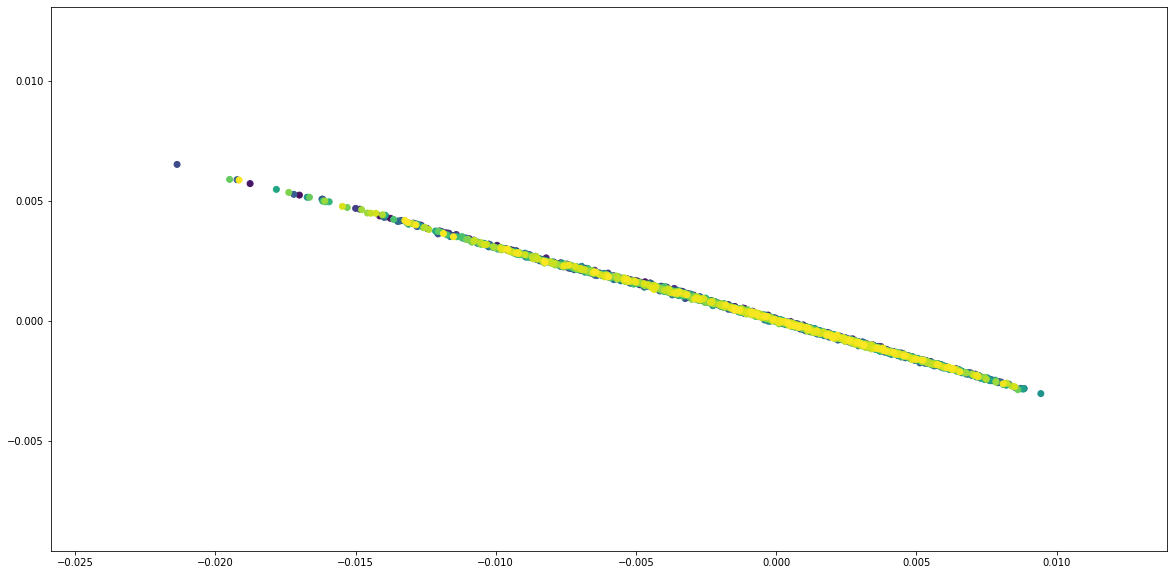

In [41]:
recon_rna, z, logvarz, muz = simple_test_vae(model_vae, test_loader)
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z[:,1], z[:,5], c=np.arange(rna.shape[0]))

In [35]:
recon_rna

tensor([[0.0493, 0.1523, 0.4999,  ..., 0.0982, 0.2377, 0.0894],
        [0.0493, 0.1523, 0.4998,  ..., 0.0982, 0.2377, 0.0894],
        [0.0493, 0.1523, 0.4999,  ..., 0.0982, 0.2377, 0.0894],
        ...,
        [0.0493, 0.1522, 0.4997,  ..., 0.0982, 0.2377, 0.0894],
        [0.0493, 0.1522, 0.4996,  ..., 0.0982, 0.2377, 0.0894],
        [0.0493, 0.1523, 0.4998,  ..., 0.0982, 0.2377, 0.0894]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [42]:
z

array([[-3.9178729e-03, -3.9170012e-03, -2.7212724e-03, ...,
         7.0783589e-04, -3.4562610e-03,  1.1118484e-04],
       [-1.8695444e-03, -1.4242455e-03, -1.0497198e-03, ...,
         2.8911792e-04, -1.2126826e-03,  6.8111694e-05],
       [-3.9752126e-03, -3.6221221e-03, -2.5890172e-03, ...,
         6.9058128e-04, -3.3525303e-03,  1.1002453e-04],
       ...,
       [ 1.6373396e-04,  7.9181045e-04,  4.5896322e-04, ...,
        -8.0691651e-05,  7.9506263e-04,  2.9939110e-06],
       [ 2.1889806e-03,  3.1303987e-03,  2.0341054e-03, ...,
        -4.7994778e-04,  2.9924884e-03, -3.4549739e-05],
       [-1.8461198e-03, -1.4661178e-03, -1.0869130e-03, ...,
         2.8996356e-04, -1.2822598e-03,  6.7271758e-05]], dtype=float32)